In [1]:
#this scripts takes the output from var_builder
#converts timedelta to numeric
#calculates backward citation average delay
#calculates forward citation average delay
#counts forward and backward citations

# Jan 19, 2020
# Joining is not generating matches
# probably is an issue with dtype
# i am running joining with inner but it should be updated later with outer.

In [2]:
import sys
sys.path.append('/home/rkogeyam/scripts/')
from sampler import sampler

import pandas as pd
import numpy as np
import re

In [3]:
%matplotlib inline

In [4]:
src='data/var_builder.csv'
cit_received_delay = 'data/cit_received_delay.csv'
cit_made_delay='data/cit_made_delay.csv'

In [5]:
cols=['patent_id','citation_id', 'cit_delay' ]
dtypes={'patent_id': object, 'citation_id': object, 'cit_delay': np.float64}
df = pd.read_csv(src, usecols=cols)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91178665 entries, 0 to 91178664
Data columns (total 3 columns):
patent_id      object
citation_id    object
cit_delay      float64
dtypes: float64(1), object(2)
memory usage: 2.0+ GB


In [7]:
df.dtypes

patent_id       object
citation_id     object
cit_delay      float64
dtype: object

In [8]:
# df['cit_delay']=pd.to_timedelta(df['cit_delay']).dt.components.days/365 
#for some reason dt.days stopped working. dt.components came around and is working

In [9]:
# output: patent-level data
# if group by citation_id, the delay will give the average delay gives how much time it took,
#    in average, for a patent to receive citations
# it is a measure of time to become influent

received_delay=df.groupby('citation_id').mean()
# back_delay.rename(columns={'count': 'back_citation', 'mean':'mean_back_delay'}, inplace=True)
received_delay.head()

,cit_delay
citation_id,
0,NaN
0000000,16.443836
000004,169.767123
000006,168.367123
0000482,105.816438


In [10]:
received_delay.dropna(inplace=True)

In [11]:
received_delay.dtypes #this will tell us if i am trying to join data of the same format

cit_delay    float64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1acb386198>]], dtype=object)

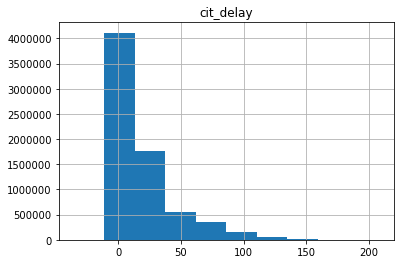

In [12]:
received_delay.hist()

In [13]:
received_delay[received_delay["cit_delay"]<received_delay["cit_delay"].quantile(0.01)]

,cit_delay
citation_id,
010500,0.728767
019850,0.621918
024538,0.660274
034752,0.843836
049377,0.547945
054325,0.775342
1001308,0.641096
1020881,0.731507
1038754,0.394521


In [14]:
received_delay[received_delay["cit_delay"]>received_delay["cit_delay"].quantile(0.99)]

,cit_delay
citation_id,
000004,169.767123
000006,168.367123
000169,172.227397
000491,164.602740
000567,153.638356
000588,165.405479
0019785,139.389041
002714,160.364384
0028174,140.345205


In [15]:
received_delay.to_csv(cit_received_delay)

In [16]:
# if you group by patent_id, the delay will give a measure of how far back the patent is rooted.

made_delay=df.groupby('patent_id').mean()
# forw_delay.rename(columns={'count': 'forw_citation', 'mean':'mean_forw_delay'}, inplace=True)
made_delay.head()

,cit_delay
patent_id,
3930271,24.738356
3930272,34.159402
3930273,16.671575
3930274,14.164384
3930275,11.854795


In [17]:
made_delay.dropna(inplace=True)

In [18]:
made_delay.dtypes

cit_delay    float64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b87e35278>]], dtype=object)

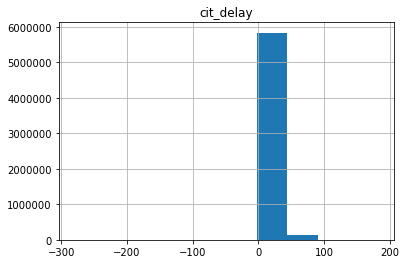

In [19]:
made_delay.hist()

In [20]:
made_delay[made_delay["cit_delay"]<made_delay["cit_delay"].quantile(0.01)].sort_values()

,cit_delay
patent_id,
3930367,1.347945
3930418,1.013699
3930461,1.376256
3930661,1.461187
3931052,1.433333
3931067,1.013699
3931105,0.928767
3931138,1.098630
3931140,1.072146


In [21]:
made_delay[made_delay["cit_delay"]>made_delay["cit_delay"].quantile(0.99)].sort_values()

,cit_delay
patent_id,
3930309,58.173386
3930316,63.225342
3930450,54.370320
3930490,56.108676
3930514,58.153973
3930525,61.726027
3930562,65.373699
3930624,59.455342
3930652,58.085274


In [22]:
made_delay.to_csv(cit_made_delay)